In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import pdfplumber

from collections import Counter
import re

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob

from tqdm import trange

In [2]:
eng_stopwords = stopwords.words("english")
Tokenizer = RegexpTokenizer(r"[A-Za-z0-9-]+")
wl=WordNetLemmatizer()

## Preparing data

In [3]:
pages = []
with pdfplumber.open("KG.pdf") as pdf:
    for i in trange(12, 273):
        pages.append(pdf.pages[i].extract_text())

100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:31<00:00,  8.28it/s]


In [4]:
letter = 'A'
chapter = ''
chapters = []
for page in pages:
    if page[:6].replace('\n', '').replace(' ', '') == letter:
        chapters.append(chapter)
        chapter = ''
        letter = chr(ord(letter) + 1)     
    else:
        chapter += page
        
    if page == pages[-1]:
        chapters.append(chapter)
        
chapters = chapters[1:]

In [5]:
pages = [page.replace('\n', '') for page in pages]
chapters = [chapter.replace('\n', '') for chapter in chapters]
all_text = ' '.join(pages)
all_sentences = nltk.tokenize.sent_tokenize(all_text)

In [6]:
f'Number of chapters (one for each letter): {len(chapters)}, number of pages: {len(pages)}'

'Number of chapters (one for each letter): 26, number of pages: 261'

## Number of characters

In [7]:
counter = dict(Counter(re.sub('[^a-z]', '', all_text.lower())))
counter = dict(sorted(counter.items(), key=lambda item: item[0]))

Text(0.5, 1.0, '...')

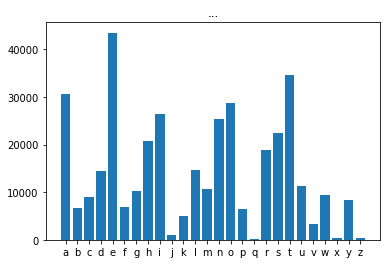

In [8]:
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.title('...')

## Number of words per one page

In [9]:
number_of_words = []
for i in range(len(pages)):
    words = pages[i].split(' ')
    words = [word for word in words if word != '']
    number_of_words.append(len(words))

(array([17., 16.,  5.,  3.,  1.,  1.,  4.,  3.,  9.,  4.,  7.,  4.,  3.,
         2., 10.,  7., 11.,  8., 13.,  7.,  5.,  7., 14.,  2.,  4., 12.,
        12.,  5.,  4.,  8., 13.,  3.,  8.,  5.,  4., 11.,  2.,  5.,  1.,
         1.]),
 array([  0.  ,  17.75,  35.5 ,  53.25,  71.  ,  88.75, 106.5 , 124.25,
        142.  , 159.75, 177.5 , 195.25, 213.  , 230.75, 248.5 , 266.25,
        284.  , 301.75, 319.5 , 337.25, 355.  , 372.75, 390.5 , 408.25,
        426.  , 443.75, 461.5 , 479.25, 497.  , 514.75, 532.5 , 550.25,
        568.  , 585.75, 603.5 , 621.25, 639.  , 656.75, 674.5 , 692.25,
        710.  ]),
 <BarContainer object of 40 artists>)

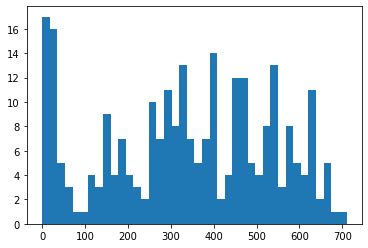

In [10]:
plt.hist(number_of_words, bins=40)

## Number of sentences per one page

In [11]:
number_of_sentences = []
for i in range(len(pages)):
    sentences = pages[i].replace(' ', '').split('.')
    sentences = [sentence for sentence in sentences if sentence != '']
    if len(sentences) > 1:      
        number_of_sentences.append(len(sentences))

(array([ 9.,  3.,  0.,  1.,  7.,  7.,  7.,  6.,  6., 10., 10.,  4.,  4.,
        16., 17.,  9., 13.,  5.,  9.,  4.,  6.,  8.,  7.,  8.,  4.,  4.,
         8.,  3.,  5., 12.,  5.,  2.,  4.,  2.,  2.,  2.,  0.,  1.,  0.,
         2.]),
 array([ 2.   ,  4.075,  6.15 ,  8.225, 10.3  , 12.375, 14.45 , 16.525,
        18.6  , 20.675, 22.75 , 24.825, 26.9  , 28.975, 31.05 , 33.125,
        35.2  , 37.275, 39.35 , 41.425, 43.5  , 45.575, 47.65 , 49.725,
        51.8  , 53.875, 55.95 , 58.025, 60.1  , 62.175, 64.25 , 66.325,
        68.4  , 70.475, 72.55 , 74.625, 76.7  , 78.775, 80.85 , 82.925,
        85.   ]),
 <BarContainer object of 40 artists>)

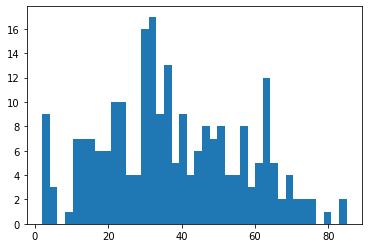

In [12]:
plt.hist(number_of_sentences, bins=40)

## The most common words used in the book

In [13]:
def finding_words(all_text):
    words = all_text.split(' ')
    words = [word for word in words if word != '']
    cleaned_words = []
    for word in words:
        word = word.lower()
        word = Tokenizer.tokenize(word)  
        if len(word) > 0:
            word = [wl.lemmatize(word[0], 'v')]
            word = word if word[0] not in eng_stopwords else ['']
            word = word if len(word[0])>2 else ['']
            
            cleaned_words.append(word[0])

    cleaned_words = [word for word in cleaned_words if word != ['']]
    cleaned_words = [word for word in cleaned_words if word != '']
    
    return cleaned_words

In [14]:
def find_the_most_common_words(comments, limit=15):
    x = Counter(comments).most_common()[:limit]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [15]:
cleaned_words = finding_words(all_text)

In [16]:
words, occurrences = find_the_most_common_words(cleaned_words, limit=15)

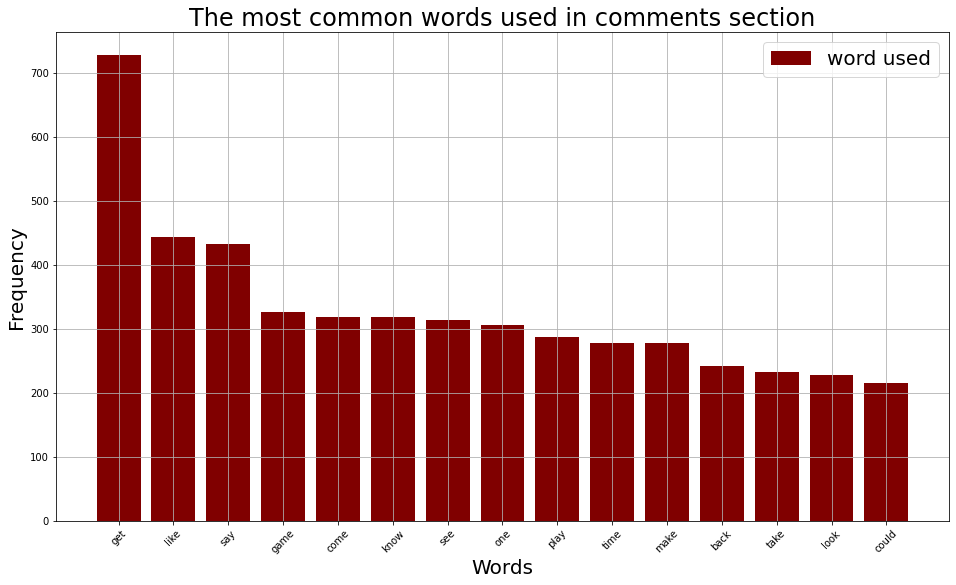

In [17]:
plt.figure(figsize=(16, 9))
plt.title('The most common words used in comments section', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='maroon')
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

## How often do the most common words appear in a single chapter?

In [18]:
top_five = list(words[:5])

In [19]:
counters_for_words = []
for word in top_five:
    counters = []
    for chapter in chapters:
        counters.append(finding_words(chapter).count(word))
        
    counters_for_words.append(counters)

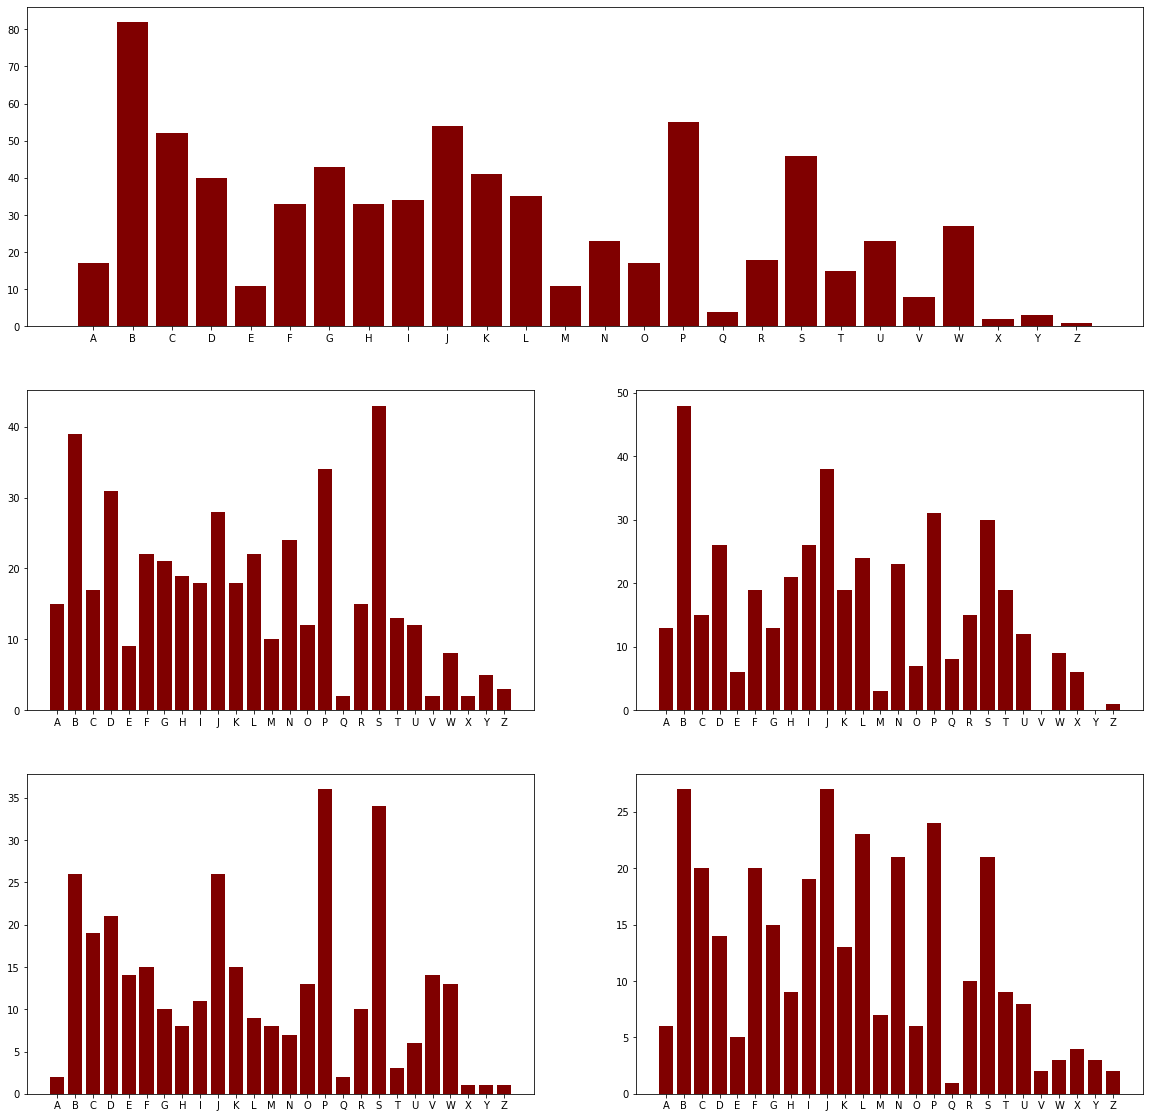

In [20]:
plt.figure(figsize=(20, 20))
for i in range(len(top_five)):
    if i == 0:
        plt.subplot(3, 1, i+1)
    else:
        plt.subplot(3, 2, i+2)
    plt.bar([chr(j) for j in range(65, 91)], counters_for_words[i], color='maroon')

## The most common noun phrases used in the book

-> maybe RegexpParser is better? - to check

In [21]:
def finding_noun_phrases(comments):
    noun_phrases_comments = []
    cleaned_comments = []
    wl=WordNetLemmatizer()
    for comment in comments:
        comment = comment.lower()
        comment = Tokenizer.tokenize(comment)
        comment = [word for word in comment if word not in eng_stopwords]
        comment = [word for word in comment if len(word)>2] 
        comment = " ".join(comment)
        comment = TextBlob(comment)
        comment = comment.noun_phrases   
        noun_phrases_comments.append(comment)

    noun_phrases_comments_combined = [word for sublist in noun_phrases_comments for word in sublist]
    
    return noun_phrases_comments_combined

In [22]:
def find_the_most_common_noun_phrases(comments, limit=15):
    x = Counter(comments).most_common()[:limit] 
    x = [phrase for phrase in x if phrase[0] != 'gon na']
    x = [phrase for phrase in x if phrase[0] != 'wan na']
    x = [phrase for phrase in x if len(phrase[0].split(' '))==2]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [23]:
words, occurrences = find_the_most_common_noun_phrases(finding_noun_phrases(chapters))

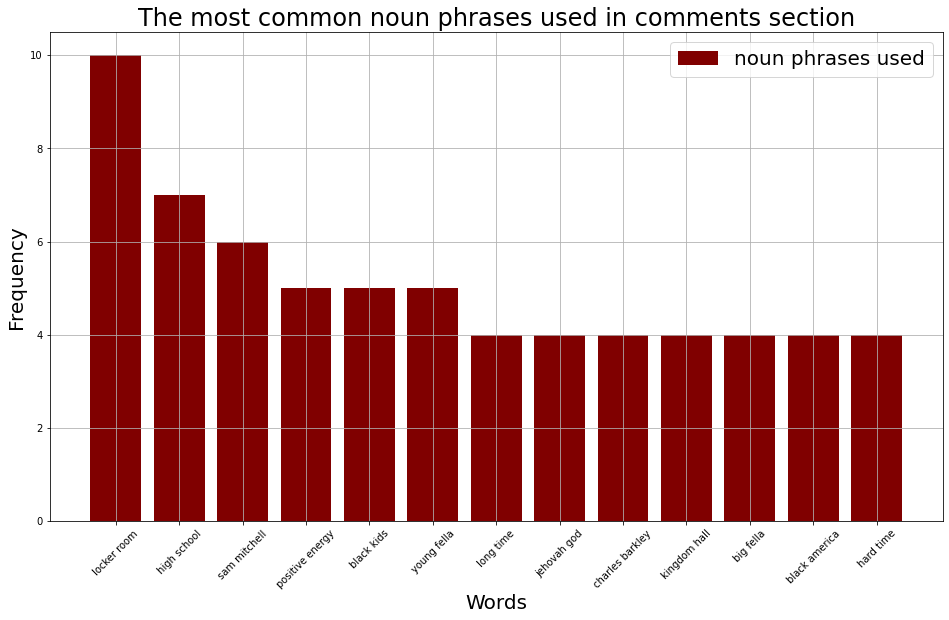

In [24]:
plt.figure(figsize=(16, 9))
plt.title('The most common noun phrases used in comments section', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='maroon')
plt.legend(['noun phrases used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

## Number of bad words

## Finding names of basketball players

## Finding cities from this book